In [8]:
global input = "C:\Users\Iyed\Desktop\Trade Analysis\Practical guide to TPA\Practical guide to TPA"

In [9]:
****************************************************************************
*********             CHAPTER 3 - ANALYZING BILATERAL              ********* 
*********		   TRADE USING THE GRAVITY EQUATION 	 	 ********* 
****************************************************************************

* The aim of this exercise is to assess the impact on trade of the formation of a
* regional trade agreement. The exercise focuses on NAFTA and refers to the 1985-2004
* period, but a similar exercise can be applied to other PTAs provided the sample
* period covers sufficient years before and after the agreement.
* The assignment is as follows.  

* Data source: Trade and production data come from the database " Trade, 
*		   Protection and Production 1976-2004 " constructed by the World 
*		   Bank (Nicita and Olarreaga 2006), and are available at 
*		   http://go.worldbank.org/EQW3W5UTP0
* 		   They only refer to manufacturing industries.



********* PRELIMINARY STEP *********
* Set memory and path 
	clear all
	set mem 800m
	set matsize 800
	graph drop _all
	set more off, perm



set memory ignored.
    Memory no longer needs to be set in modern Statas; memory adjustments are performed on the fly automatically.



(set more preference recorded)


In [10]:
	
* Open database
	
	cd "$input/Chapter3/Datasets"

C:\Users\Iyed\Desktop\Trade Analysis\Practical guide to TPA\Practical guide to TPA\Chapter3\Datasets


In [11]:
*********    QUESTIONS    ********* 

* 1. Preliminaries
* Import in STATA the Trade, Protection and Production data base constructed
* by the World Bank (Nicita and Olarreaga 2006) available in the folder
* Datasets/original/TPP and merge it with trade data in Datasets/original/
* Bilateral trade for the period 1985-2004. Then aggregate data at the 
* country level. Note that this process may take time as you need to load
* a large database. For this reason you also may need to set memory at a high
* level (eg. 800m).  The do file to construct the data can be found at 
* Module 2/THEME 3/Exercises/AnalyzingBilateralTradeUsingGravity/Datafile Creation.


* a)	Define a dummy variable equal to one for intra-NAFTA trade (i.e. between Canada,
* Mexico and US since 1994 the year of entry into force of NAFTA), and another
* one for each NAFTA's country import from the rest of the world (i.e. build
* the dummies to measure trade creation and trade diversion ).Define a dummy variable
* equal to one for intra-NAFTA trade (i.e. between Canada, 

* Open the database 	
	use "agGravityData.dta", replace

* Create NAFTA dummies since 1994
	gen nafta = (ccode=="CAN" | ccode=="MEX" | ccode=="USA") 
	label var nafta "1 if home is nafta member"
	gen pnafta = (pcode=="CAN" | pcode=="MEX" | pcode=="USA") 
	label var pnafta "1 if partner is nafta member"
	gen intra_nafta =  (ccode=="CAN" | ccode=="MEX" | ccode=="USA")  & (pcode=="CAN" | pcode=="MEX" | pcode=="USA") 
	replace intra_nafta = 0 if year < 1994
	label var intra_nafta "1 if trade bewteen nafta members"
	gen imp_nafta_rest = (ccode=="CAN" | ccode=="MEX" | ccode=="USA") & (pcode!="CAN" & pcode!="MEX" & pcode!="USA") 
	replace imp_nafta_rest = 0 if year < 1994
	label var imp_nafta_rest "1 if nafta's imports from the rest of the world"

* Save database
	save "agGravityDataNAFTA.dta", replace








(80 real changes made)



(5399 real changes made)


(note: file agGravityDataNAFTA.dta not found)
file agGravityDataNAFTA.dta saved




(248991 observations deleted)


(27 missing values generated)

(27 real changes made)


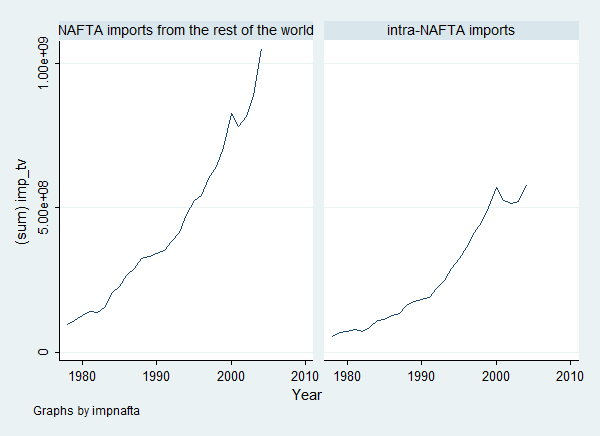






C:\Users\Iyed\Desktop\Trade Analysis\Practical guide to TPA\Practical guide to TPA\Chapter3\Exercises\1_Estimating the impact of a Regional Trade Agreement\Results

(file NAFTAimp.gph saved)


In [12]:
* b)	Plot the temporal evolution of intra-NAFTA imports and of NAFTA's imports from 
*	the rest of the world. Comment. 
	use "agGravityDataNAFTA.dta", replace
	keep if nafta == 1
	collapse(sum) imp_tv , by( pnafta year)
	gen impnafta = "NAFTA imports from the rest of the world"  if pnafta ~= 1
	replace impnafta = "intra-NAFTA imports" if pnafta == 1
	label define impnafta 1 "NAFTA imports from the rest of the world"  0 "intra-NAFTA imports"
 	twoway (tsline imp_tv), by(impnafta )
	*twoway (tsline imp_tv if impnafta == "intra-NAFTA imports" ) (tsline imp_tv if impnafta == "NAFTA imports from the rest of the world" )	
	
	cd "$input/Chapter3/Exercises/1_Estimating the impact of a Regional Trade Agreement/Results"
	graph save "NAFTAimp.gph", replace


       panel variable:  pnafta (strongly balanced)
        time variable:  year, 1978 to 2004
                delta:  1 unit

(2 missing values generated)


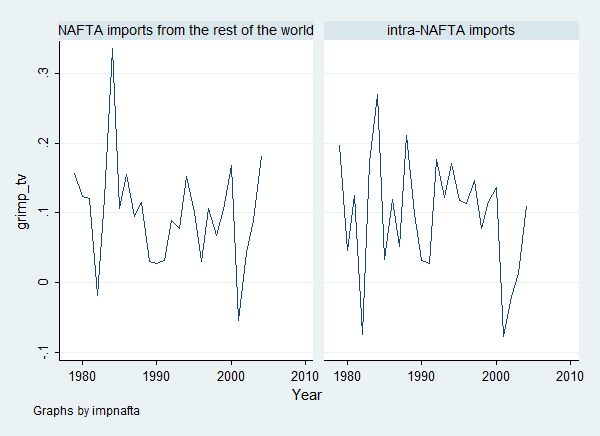






(file NAFTAgrimp.gph saved)


In [13]:
	* redo graph with growth rate
	tsset pnafta year
	gen grimp_tv = (imp_tv - l1.imp_tv) / l1.imp_tv
	twoway (tsline grimp_tv), by(impnafta )
	xtline grimp_tv, overlay ytitle(Imports Growth Rate) ttitle(Year) tmtick(, valuelabel) title(Growth Rate of NAFTA's Imports) legend(order(1 "Rest of the World" 2 "Intra-NAFTA"))
	graph save "NAFTAgrimp.gph", replace
	

In [14]:
* 2. Average trade creation and diversion
* a)	Introduce the two above dummies in a gravity equation (fixed effects model with 
*	country-pair fixed effects and year dummies) estimated on all countries, not just
*	the countries involved.

	* The gravity model reads as ln(Vijt) = cst + a1*ln(GDPit) + a2*ln(GDPjt) +
	* a3*ln(Dij) + a4*Ii + a5*Ii + TimeDummies + uijt
	* where: Vijt = trade flows between country i and j at year t
	*	   GDPit = GDP in country i at time t
	*  	   Dij = bilateral distance between i and j
	* 	   Ii = 1 if it country i
	*	   uij = individual fixed effect and error term

* Open the database

	cd "$input/Chapter3/Datasets"
	use "agGravityDataNAFTA.dta", replace

* Create panel identifier, here it is the country pair
	*drop id
	egen id = group(ccode pcode)
	tsset id year

* Create the variables in log
	gen lnV = log(imp_tv)
	label var lnV "value of imported goods in logarithm"
	gen lncGDP = log(cgdp_current)
	label var lncGDP "partner's current GDP in logarithm"
	gen lnpGDP = log(pgdp_current)
	label var lnpGDP "home's current GDP in logarithm"
	gen lnD = log(km)
	label var lnD "bilateral distance in logarithm"

* Two possibilities to estimate the model with time dummies, the second one being the cleanest way
* 1. Create the dummies and estimate
	quietly tabulate year, gen(yr) 
	*xtreg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest country* partner* yr*, fe vce(robust)
	*reg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest country* partner* yr*,  vce(robust)
	xtreg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest yr*, fe vce(robust)

* 2. Estimate by specifying the dummies and Stata estimate the model with them implicitely
	*xi: xtreg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest i.ccode i.pcode i.year, fe vce(robust)
	*xi: reg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest i.ccode i.pcode i.year, vce(robust)
	xi: xtreg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest  i.year, fe vce(robust)
	
	cd "$input/Chapter3/Exercises/1_Estimating the impact of a Regional Trade Agreement/Results"
	outreg2 lncGDP lnpGDP lnD intra_nafta imp_nafta_rest using "GravityResults.txt", replace addnote(Estimation with country-pair fixed effects and year dummies, 2nd colum include interaction terms between NAFTA dummies and time dummies)
	cd "$input/Chapter3/Datasets"

* Save the database so we dont need to recompute the log of the variables
	save "agGravityDataNAFTA.dta", replace
	


C:\Users\Iyed\Desktop\Trade Analysis\Practical guide to TPA\Practical guide to TPA\Chapter3\Datasets



       panel variable:  id (unbalanced)
        time variable:  year, 1976 to 2004, but with gaps
                delta:  1 unit

(33022 missing values generated)


(1976 missing values generated)


(16808 missing values generated)





note: lnD omitted because of collinearity
note: yr29 omitted because of collinearity

Fixed-effects (within) regression               Number of obs      =    211406
Group variable: id                              Number of groups   =     15728

R-sq:  within  = 0.1872                         Obs per group: min =         1
       between = 0.5011                                        avg =      13.4
       overall = 0.4549                                        max =        29

                                                F(32,15727)        =    307.61
corr(u_i, Xb)  = 0.2224                         Prob > F           =    0.0000

                

In [16]:
* b)	Present results and interpret the coefficients associated with the
* 	dummies (i.e. quantify the trade creation/diversion). 
*	The results are saved in a txt file using outreg2

* 3. Evolution of trade creation and diversion
* a)	Interact the two NAFTA dummies (denoting intra and extra NAFTA country
* 	pairs) with year effects and introduce them into the gravity equation
* 	(with still a fixed effects model with country-pair fixed effects and
*	year dummies).

	use "agGravityDataNAFTA.dta", replace

* Again 2 possibilities to create dummies, the second one is the most clean but the first one better to
* handle for the next sub-question.
* 1. Create the dummies and estimate
	levelsof year, local(time)
	foreach t of local time {
		local y_rr = `t' - 1975 
		gen intra_nafta`t' = yr`y_rr' * intra_nafta
		gen imp_nafta_rest`t' = yr`y_rr' * imp_nafta_rest
	}

	xtreg lnV lncGDP lnpGDP lnD  yr* intra_nafta* imp_nafta_rest*, fe vce(robust)
	
	cd "$input/Chapter3/Exercises/1_Estimating the impact of a Regional Trade Agreement/Results"
	outreg2 lncGDP lnpGDP lnD intra_nafta imp_nafta_rest using "GravityResults.txt", append addnote(Estimation with country-pair fixed effects, year dummies and interaction dummies between NAFTA and time dummies)
	cd "$input/Chapter3/Datasets"
	



1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004


note: lnD omitted because of collinearity
note: yr29 omitted because of collinearity
note: intra_nafta1976 omitted because of collinearity
note: intra_nafta1977 omitted because of collinearity
note: intra_nafta1978 omitted because of collinearity
note: intra_nafta1979 omitted because of collinearity
note: intra_nafta1980 omitted because of collinearity
note: intra_nafta1981 omitted because of collinearity
note: intra_nafta1982 omitted because of collinearity
note: intra_nafta1983 omitted because of collinearity
note: intra_nafta1984 omitted because of collinearity
note: intra_nafta1985 omitted because of collinearity
note: intra_nafta1986 omitted because of collinearity
note: intra_nafta1987 omitted because of collinearity
note: intra_nafta1988 omitted because of collinearity
note: intra_nafta1989 omitted because of collinearity
note: intr

In [ ]:
* 2. Estimate by specifying the dummies and Stata estimate the model with them implicitely
	*xi: xtreg lnV lncGDP lnpGDP lnD  i.year i.year*intra_nafta i.year*imp_nafta_rest , fe vce(robust)
	*outreg2 lncGDP lnpGDP lnD intra_nafta imp_nafta using "Chapter3/Exercises/GravityResults.txt", append addnote(Estimation with country-pair fixed effects, year dummies and interaction dummies between NAFTA and time dummies)

* b)	Plot the temporal evolution of the coefficient of the NAFTA-year interaction
*	variables and interpret the evolution of the coefficients in terms
* 	of trade creation and trade diversion. 


/* 	
************************************
This part only works with Stata 10
************************************

Retrieve the estimated coefficients, so dont clear the computer's memory. Note that in stata the 
* coefficients are in a row-vector. Note also the position of the respective coefficients
	matrix coefs = e(b)
	matrix params = coefs'
	drop *
	svmat double coefs, names( matcol )
	keep  coefsimp_nafta_rest* coefsintra_nafta*
	order coef*
	mkmat coefsimp_nafta*, matrix(imp)
	mkmat coefsintra_nafta*, matrix(intra)
	matrix imptr = imp'
	matrix intra = intra'
	svmat imptr
	rename imptr tradediversion
	svmat intra
	rename intra tradecreation
	drop coef*
	gen year = _n
	drop if year == 1
	replace year = year + 1974

* Export these results in a table in txt
	outsheet using "$input/Chapter3/Applications/Results/TradeCreationDiversion.txt", replace
	
* Plot the graph
	tsset year
	twoway (tsline tradediversion if year >= 1994) (tsline tradecreation if year >= 1994), title(NAFTA's Evolution of Trade Creation and Diversion) legend(order(1  "Trade diversion" 2  "Trade creation"))
	graph save "$input/Chapter3/Applications/Results/TradeCreationDiversion.gph", replace
*/

In [17]:
* 4. Export diversion?
* a)	Add one dummy capturing the exports of NAFTA towards the rest of the world and add
*	this third RTA dummy in the gravity equation.

* Open the database
	use "agGravityDataNAFTA.dta", clear

* Create the additional NAFTA export dummy
	gen exp_nafta_rest = (pcode=="CAN" | pcode=="MEX" | pcode=="USA") & (ccode!="CAN" & ccode!="MEX" & ccode!="USA") 
	replace exp_nafta_rest = 0 if year < 1994
	label var exp_nafta_rest "1 if nafta's exports to the rest of the world"

* Estimate the gravity model with the additional variables
	xtreg lnV lncGDP lnpGDP lnD intra_nafta imp_nafta_rest exp_nafta_rest yr*, fe vce(robust)
	
	cd "$input/Chapter3/Exercises/1_Estimating the impact of a Regional Trade Agreement/Results"
	outreg2 lncGDP lnpGDP lnD intra_nafta imp_nafta_rest exp_nafta_rest using "GravityResults.txt", append 
	cd "$input/Chapter3/Datasets"

* Save the database
	save "agGravityDataNAFTA.dta", replace




(3276 real changes made)


note: lnD omitted because of collinearity
note: yr29 omitted because of collinearity

Fixed-effects (within) regression               Number of obs      =    211406
Group variable: id                              Number of groups   =     15728

R-sq:  within  = 0.1872                         Obs per group: min =         1
       between = 0.5011                                        avg =      13.4
       overall = 0.4549                                        max =        29

                                                F(33,15727)        =    306.78
corr(u_i, Xb)  = 0.2225                         Prob > F           =    0.0000

                                   (Std. Err. adjusted for 15728 clusters in id)
--------------------------------------------------------------------------------
               |               Robust
           lnV |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
---------------+-------------------------------



(29 missing values generated)

(29 real changes made)


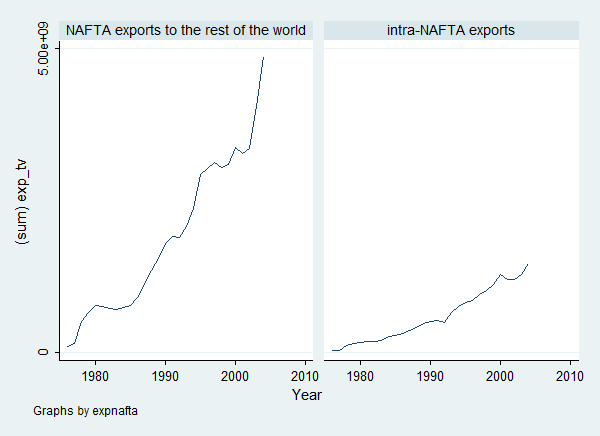






C:\Users\Iyed\Desktop\Trade Analysis\Practical guide to TPA\Practical guide to TPA\Chapter3\Exercises\1_Estimating the impact of a Regional Trade Agreement\Results

(file NAFTAexp.gph saved)

C:\Users\Iyed\Desktop\Trade Analysis\Practical guide to TPA\Practical guide to TPA\Chapter3\Datasets


1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004


note: lnD omitted because of collinearity
note: yr29 omitted because of collinearity
note: intra_nafta_1976 omitted because of collinearity
note: intra_nafta_1977 omitted because of collinearity
note: intra_nafta_1978 omitted because of collinearity
note: intra_nafta_1979 omitted because of collinearity
note: intra_nafta_1980 omitted because of collinearity
note: intra_nafta_1981 omitted because of collinearity
note: intra_nafta_1982 omitted because of collinearity
note: intra_nafta_1983 omitted because of collinearity
note: intra_nafta_1984 omitt

In [18]:
* b)	Repeat Question 1b, 2b, 3a and 3b using this new variable in addition to the others. 
*	Comment all your results.

* Plot the evolution of NAFTA's exports to the rest of the world
	collapse(sum) exp_tv , by( pnafta year)
	gen expnafta = "NAFTA exports to the rest of the world"  if pnafta ~= 1
	replace expnafta = "intra-NAFTA exports" if pnafta == 1
	label define expnafta 1 "NAFTA exports from the rest of the world"  0 "intra-NAFTA exports"
 	twoway (tsline exp_tv), by(expnafta )
	
	cd "$input/Chapter3/Exercises/1_Estimating the impact of a Regional Trade Agreement/Results"
	graph save "NAFTAexp.gph", replace
	
* Comment the gravity results 
	* export the results to the txt table was done previously with outreg2

* Reestimate the gravity model with interaction terms between NAFTA dummies and time dummies
		cd "$input/Chapter3/Datasets"

		use "agGravityDataNAFTA.dta", clear

	levelsof year, local(time)
	foreach t of local time {
		local yrr = `t' - 1975
		gen intra_nafta_`t' = yr`yrr' * intra_nafta
		gen imp_nafta_rest_`t' = yr`yrr' * imp_nafta_rest
		gen exp_nafta_rest_`t' = yr`yrr' * exp_nafta_rest	
	}

	xtreg lnV lncGDP lnpGDP lnD  yr* intra_nafta* imp_nafta_rest* exp_nafta_rest*, fe vce(robust)
	
	cd "$input/Chapter3/Exercises/1_Estimating the impact of a Regional Trade Agreement/Results"
	outreg2 using "GravityResults.txt", append addnote(Estimation with country-pair fixed effects, year dummies and interaction dummies between NAFTA and time dummies)
	cd "$input/Chapter3/Datasets"

graph drop _all

/*	
************************************
This part only works with Stata 10
************************************

* Retrieve the estimated coefficients, so dont clear the computer's memory. Note that in stata the 
* coefficients are in a row-vector. Note also the position of the respective coefficients
	matrix coefs = e(b)
	matrix params = coefs'
	drop *
	svmat double coefs, names( matcol )
	keep  coefsimp_nafta_rest* coefsintra_nafta* coefsexp_nafta*
	order coef*
	mkmat coefsimp_nafta*, matrix(imp)
	mkmat coefsintra_nafta*, matrix(intra)
	mkmat coefsexp_nafta*, matrix(exp)
	matrix imptr = imp'
	matrix intra = intra'
	matrix exp = exp'
	svmat imptr
	rename imptr tradediversion
	svmat intra
	rename intra tradecreation
	svmat exp
	rename exp exportdiversion
	drop coef*
	gen year = _n
	drop if year == 1
	replace year = year + 1974
	replace exportdiversion = . if year > 1994 & exportdiversion == 0

* Export these results in a table in txt
	outsheet using "$input/Chapter3/Applications/Results/TradeCreationDiversionExportDiversion.txt", replace

* Plot the graph
	tsset year
	twoway (tsline tradediversion if year >= 1994) (tsline tradecreation if year >= 1994) (tsline exportdiversion if year >= 1994),  title(NAFTA's Evolution of Trade Creation and Diversion and Export Diversion, size(medsmall)) ttitle(Year) ytitle(coefficient)  legend(order(1  "Trade diversion" 2  "Trade creation" 3 "Export diversion"))
	graph save "$input/Chapter3/Applications/Results/TradeCreationDiversionExportDiversion.gph", replace
*/

erase agGravityDataNAFTA.dta

exit
exit
exit